In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.Linebot設計

In [ ]:
pip install flask-ngrok

In [ ]:
pip install line-bot-sdk

In [ ]:
'''
當query包含"身高"、"體重"、"年齡"、"收入"等隱私時，回覆以下貼圖
'''

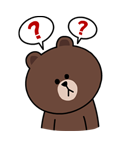

In [ ]:
from IPython.display import Image 
Image(filename='play_dumb.PNG') 

In [ ]:
from __future__ import unicode_literals
import os, requests, json, configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from flask_ngrok import run_with_ngrok
from linebot.exceptions import InvalidSignatureError
from linebot.models import *


app = Flask(__name__)

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/NLP/cupoy_config.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))
run_with_ngrok(app) # Start ngrok when app is run
# 接收 LINE 資訊
    
@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)

    try:
        print("body:",body)
        print("signature:", signature)
        print("===")
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

# 回覆設定 (defaul僅能回固定語句)
@handler.add(MessageEvent, message=TextMessage)
def handle_text_message(event):
    query = event.message.text
    NG_words = ["身高","體重","年齡","收入"]

    StickerMessage = StickerSendMessage(package_id="11537", sticker_id="52002744")
    if any([word in query for word in NG_words]):
        line_bot_api.reply_message(event.reply_token, StickerMessage)
    else:   
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="不論你說什麼 我都回你好!"))

if __name__ == '__main__':
    app.run()
 


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://918c0f111e6a.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [09/May/2021 16:09:23] "POST /callback HTTP/1.1" 200 -


body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[]}
signature: pei5oGwahjp79pKPRVHOEza4csK0r4ce6mciXE+TaAA=
===
body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14023494003795","text":"你的身高"},"timestamp":1620576580465,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"1498124568b240e3a6434bdc602ff375","mode":"active"}]}
signature: e07luW5jW3uPr6ulzKvFhGep+NUSCQEi0glnxy1ttfI=
===


127.0.0.1 - - [09/May/2021 16:09:42] "POST /callback HTTP/1.1" 200 -


## 3.以Python實現多輪對話<br>
pip install yfinance

In [ ]:
pip install yfinance

In [8]:
#抓取儲存股票名稱
def get_stock_name():
    # current date and time
    company2symbol = {}
    now = datetime.now()
    timestamp = datetime.timestamp(now)
    filters = ['0'+str(i) for i in range(1,10)]
    filters.extend([str(i) for i in range(10,32)])

    for filter in filters:

        url = 'https://www.twse.com.tw/zh/api/codeFilters?'
        headers = {
            'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Mobile Safari/537.36',
            'Referer': 'https://www.twse.com.tw/zh/page/trading/exchange/STOCK_DAY.html'
        }
        params = {
            'filter': str(filter),
            '_': timestamp
        }
        res = requests.get(url,headers=headers,params=params)
        jdatas = json.loads(res.text)['resualt']
        for data in jdatas:
            symbol = data.split('\t')[0]
            company = data.split('\t')[1]
            company2symbol[company] = symbol
       
        time.sleep(1)
        
    return company2symbol

def save_company2symbol(company2symbol):
    df_symbol = pd.DataFrame.from_dict(company2symbol,orient='index')
    df_symbol.columns = ['symbol']
    df_symbol.to_csv('/content/drive/MyDrive/NLP/symbol.csv')
    return df_symbol

#抓取股票資料
def get_stock_price(df_symbol,query,start,end):   
    symbol = df_symbol.loc[query].symbol+'.TW'
    data = yf.download(symbol, start=start, end=end)
    return data

#只取收盤價
def get_selected_info(data,columns,query,symbol_name):
    message=f'{symbol_name} \n'
    for idx, row in data.iterrows():
        message += f'*{idx.date()}的{query}為{row[columns[query]]} \n'
    return message

#company2symbol = get_stock_name()
#df_symbol = save_company2symbol(company2symbol)

In [ ]:
'''
於多輪對話情境中加入"取得股價資訊的功能"，query為公司簡稱時(ex.鴻海)，即輸出2020/12/1 ~12/10之股價資訊
'''

In [7]:
from __future__ import unicode_literals
from datetime import datetime, timedelta
import pandas as pd
import os, requests, json, configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import *
from flask_ngrok import run_with_ngrok
import time
import yfinance as yf
import re
import stock_utils2
import thsr_utils as Thsr
thsr = Thsr.ThsrModule()


chat_record = []
symbol_res = {"starting":"", "ending":"", "symbol":"", "column":""}
columns = {'開盤價':'Open','高點':'High','低點':'Low','收盤價':'Close','成交量':'Volume'}

thsr_res = {"starting":"", "ending":"", "date":"", "ampm":""}
station_names = Thsr.station_name
date_keys = Thsr.date_key
ampm_keys = Thsr.ampm_key

symbol_name_list_path = '/content/drive/MyDrive/NLP/symbol.csv'
# 先確認是否有股票名稱資訊 有→讀取、沒有→下載
try:
    df_symbol = pd.read_csv(symbol_name_list_path,index_col=0)

except FileNotFoundError:
    company2symbol = stock_utils2.get_stock_name()
    df_symbol = stock_utils2.save_company2symbol(company2symbol,symbol_name_list_path)
    print('stock_name_data downloaded')

app = Flask(__name__)
run_with_ngrok(app) # Start ngrok when app is run

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('/content/drive/MyDrive/NLP/cupoy_config.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))

# 接收 LINE 資訊
@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)

    try:
        print("body:",body)
        print("signature:", signature)
        print("===")
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

# 回覆設定 (加入高鐵和股價API多輪對話)
@handler.add(MessageEvent, message=TextMessage)
def get_response(event):
    query = event.message.text       
    
    if len(chat_record) < 5:
        chat_record.append(query)
    else:
        chat_record.pop(0)
        chat_record.append(query)
    print("chat_record:",chat_record)


    # 判斷是否為"股價查詢意圖"
    if query == '股票':
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="請輸入公司簡稱"))
    
    # 判斷是否為"高鐵查詢意圖"    
    elif query == '高鐵':
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="哪一天出發?"))           

    try:
        #股票相關訊息處理
        if chat_record[-2] == '股票' and chat_record[-1] in list(df_symbol.index):
            symbol_res["symbol"] = chat_record[-1]
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="請輸入想查詢區間(格式→單日:2021-01-04，多日:2021-01-04~2020-01-06"))


        elif chat_record[-2] in list(df_symbol.index) and len(re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}',chat_record[-1]))!=[]:
            dates = re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}',chat_record[-1])
            if len(dates) == 1:
                symbol_res["starting"] = dates[0]
                ending = datetime.strptime(dates[0], '%Y-%m-%d').date()+timedelta(days=1)
                symbol_res["ending"] = str(ending)

            elif len(dates)== 2:
                symbol_res["starting"] = dates[0]
                symbol_res["ending"] = dates[1]
            
            else: #len(dates)>2
                chat_record.pop(-1)
                line_bot_api.reply_message(event.reply_token, TextSendMessage(text="日期格式錯誤，請重新輸入"))

            #成功獲取日期訊息後先確認是否有資料    
            data = stock_utils2.get_stock_price(df_symbol,symbol_res["symbol"],symbol_res["starting"],symbol_res["ending"])
            if data.empty == False:
                line_bot_api.reply_message(event.reply_token, TextSendMessage(text="想查詢什麼資訊呢?(請輸入:收盤價、開盤價、高點、低點、成交量)"))
            else:
                chat_record.pop(-1)
                line_bot_api.reply_message(event.reply_token, TextSendMessage(text='抱歉 沒有此股票or區間資訊，請重新輸入日期 或 重新輸入"股票"查詢'))

        
        elif len(re.findall('[0-9]{4}-[0-9]{2}-[0-9]{2}',chat_record[-2]))!=[] and any(chat_record[-1] == i for i in columns):
            symbol_res['column'] = chat_record[-1]
            data = stock_utils2.get_stock_price(df_symbol,symbol_res["symbol"],symbol_res["starting"],symbol_res["ending"])
            message = stock_utils2.get_selected_info(data,columns,symbol_res['column'],symbol_res['symbol'])
            print("***",message)

            line_bot_api.reply_message(event.reply_token, TextSendMessage(text=message))

        #高鐵相關訊息處理
        elif chat_record[-2] == "高鐵" and any(chat_record[-1] == i for i in date_keys):
            date_format = thsr.get_date_string_today(chat_record[-1])
            thsr_res['date'] = date_format
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="上午還是下午的車?"))

        elif any(chat_record[-2] == i for i in date_keys) and any(chat_record[-1] == i for i in ampm_keys):
            thsr_res['ampm'] = chat_record[-1]
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="起站是哪裡呢?"))

        elif any(chat_record[-2] == i for i in ampm_keys) and any(chat_record[-1] == i for i in station_names):
            startind_id = Thsr.station_id[chat_record[-1]]
            thsr_res['starting'] = startind_id
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="終點站是哪裡呢?"))

        elif any(chat_record[-2] == i for i in station_names) and any(chat_record[-1] == i for i in station_names):
            ending_id = Thsr.station_id[chat_record[-1]]
            thsr_res['ending'] = ending_id

            print("***",thsr_res['starting'],thsr_res['ending'],thsr_res['date'],thsr_res['ampm'])
            text = thsr.get_runs(thsr_res['starting'],thsr_res['ending'],thsr_res['date'],thsr_res['ampm'])
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text=text))

    except IndexError:
        pass
    
         
    line_bot_api.reply_message(event.reply_token, TextSendMessage(text="不論你說什麼 我都回你好!"))

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a76da21705c8.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [10/May/2021 12:34:37] "POST /callback HTTP/1.1" 200 -


body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[]}
signature: pei5oGwahjp79pKPRVHOEza4csK0r4ce6mciXE+TaAA=
===
body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027985388175","text":"股票"},"timestamp":1620650088100,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"dd41f0fdf02c45e490754109df33acc4","mode":"active"}]}
signature: Uwt3jpKbnOpy7L2QeFX4BxoMZvYYSf+EvgNrl6KHoEA=
===
chat_record: ['股票']


[2021-05-10 12:34:49,650] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027985951101","text":"台泥"},"timestamp":1620650094442,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"dc0df7ca58f14a1abc2d08839da82389","mode":"active"}]}
signature: Y1z8/CmLwiQj+gLytMwlKSUUv8LxkbVdY8ClSyvppUA=
===
chat_record: ['股票', '台泥']


[2021-05-10 12:34:55,914] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027990723461","text":"2021-05-05…2021-05-10"},"timestamp":1620650148463,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"82e5a9f3b76a4ba4a1703b310f2d46e4","mode":"active"}]}
signature: wy3YBSY2ApxWnuj0nE4Qvwh/cvfbK1IMgvHtDbmY0JU=
===
chat_record: ['股票', '台泥', '2021-05-05…2021-05-10']
[*********************100%***********************]  1 of 1 completed


[2021-05-10 12:35:50,191] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027991520564","text":"收盤價"},"timestamp":1620650157445,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"2c529d0acc81446b8bccd15ca3d9678a","mode":"active"}]}
signature: tYCPYbKov7XYXsxrNWzz3kHxjIxU2KJ+lRbbRceIvu4=
===
chat_record: ['股票', '台泥', '2021-05-05…2021-05-10', '收盤價']
[*********************100%***********************]  1 of 1 completed
*** 台泥 收盤價 
*2021-05-05    50.79999923706055 
*2021-05-06    53.0 
*2021-05-07    52.29999923706055 



[2021-05-10 12:35:58,751] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027994014764","text":"高鐵"},"timestamp":1620650185708,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"53df7c2cef61458b8d14105edfe01d26","mode":"active"}]}
signature: zufEa9Y1RvC+DEUznDNTTPw3IU6HxcRLb9BqhELPLhg=
===
chat_record: ['股票', '台泥', '2021-05-05…2021-05-10', '收盤價', '高鐵']


[2021-05-10 12:36:27,216] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027994308877","text":"明天"},"timestamp":1620650189093,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"1c770e16eac24ac894fa041b755a2749","mode":"active"}]}
signature: 4+TqGfpCu6e0EsAstbt5NRXXGMBnynAju6f3pz3eks8=
===
chat_record: ['台泥', '2021-05-05…2021-05-10', '收盤價', '高鐵', '明天']


[2021-05-10 12:36:30,398] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027994675814","text":"下午"},"timestamp":1620650193318,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"183a3ce8eefa4b279366e261e254f4c3","mode":"active"}]}
signature: lAgb1zKSdLbEQWL5MdlMF0JOLZDRy+N7LWeB9mqgrbY=
===
chat_record: ['2021-05-05…2021-05-10', '收盤價', '高鐵', '明天', '下午']


[2021-05-10 12:36:34,752] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027995041517","text":"台北"},"timestamp":1620650197391,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"c548254457c94a41b457faafc82c27f4","mode":"active"}]}
signature: c6jtsoQQZm3CupMTfQM/rj+ideNOXwuQ5yVkdyDs+M8=
===
chat_record: ['收盤價', '高鐵', '明天', '下午', '台北']


[2021-05-10 12:36:38,566] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 

body: {"destination":"Ued67220c7a37c0abe215365e4786381a","events":[{"type":"message","message":{"type":"text","id":"14027995338034","text":"板橋"},"timestamp":1620650200760,"source":{"type":"user","userId":"Ub5065eefc75aa39c0cf2b5080c43f237"},"replyToken":"00dcb689872d4b4d96836bb7ca337741","mode":"active"}]}
signature: gBQD53CTWtykLwSvBxmDd50LX3dD4VnfLkA0OMw2Dbo=
===
chat_record: ['高鐵', '明天', '下午', '台北', '板橋']
*** 1000 1010 2021-05-11 下午


[2021-05-10 12:36:42,664] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-7-7ad5d0979554>", line 57, in callback
    handler.handle(body, signature)
  File 